In [11]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

driver = webdriver.Chrome()
url = "https://www.eduskunta.fi/FI/search/Sivut/Vaskiresults.aspx#Default=%7B%22k%22%3A%22ilmastonmuutos%22%2C%22o%22%3A%5B%7B%22p%22%3A%22Valtiopaivavuositeksti%22%2C%22d%22%3A0%7D%5D%2C%22r%22%3A%5B%7B%22n%22%3A%22Asiakirjatyyppinimi%22%2C%22t%22%3A%5B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%5D%2C%22o%22%3A%22AND%22%2C%22k%22%3Afalse%2C%22m%22%3A%7B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%3A%22Puheenvuoro%22%7D%7D%5D%2C%22l%22%3A1035%7D"
driver.get(url)
time.sleep(5)

lines = [] 

while True:
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    for item in soup.select('.ms-srch-item'):
        date_div = item.find('div', class_='ms-srch-item-summary')
        date = date_div.text.strip() if date_div else ""
        puhuja_div = item.find('div', class_='edk-srch-tmpl-puhuja')
        puhuja = puhuja_div.get_text(strip=True).replace("Puhuja: ", "") if puhuja_div else ""
        lines.append(f"{date} Puhuja:{puhuja}")  # <--- Save instead of print()

    try:
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//span[normalize-space(text())='Seuraava']/.."))
        )
        driver.execute_script("arguments[0].scrollIntoView();", next_button)
        next_button.click()
        time.sleep(3)
    except (TimeoutException, NoSuchElementException):
        print("No more pages.")
        break

driver.quit()

No more pages.


In [23]:
import pandas as pd

# Example: lines = ["24.5.2023 Puhuja:Matti Meikäläinen", "15.3.2022 Puhuja:Anna Esimerkki"]
data = []
for line in lines:
    if "Puhuja:" in line:
        date, puhuja = line.split(" Puhuja:", 1)
        data.append({"date": date.strip(), "puhuja": puhuja.strip()})
    else:
        data.append({"date": line.strip(), "puhuja": ""})

df_ilmasto = pd.DataFrame(data)
print(df.head())

                                  date                         puhuja
0  Maanantai 14.12.2015 klo 12.01—0.39      Puhuja:Andersson Li (vas)
1  Maanantai 14.12.2015 klo 12.01—0.39  Puhuja:Mikkonen Krista (vihr)
2  Maanantai 14.12.2015 klo 12.01—0.39  Puhuja:Pakkanen Markku (kesk)
3  Maanantai 14.12.2015 klo 12.01—0.39      Puhuja:Mykkänen Kai (kok)
4  Maanantai 14.12.2015 klo 12.01—0.39    Puhuja:Katainen Elsi (kesk)


In [25]:
import pandas as pd
import re

data = []
for line in lines:
    if "Puhuja:" in line:
        date_part, puhuja_part = line.split(" Puhuja:", 1)
        # Extract date using regex: looks for dd.mm.yyyy pattern
        match = re.search(r"\d{1,2}\.\d{1,2}\.\d{4}", date_part)
        if match:
            date_clean = match.group()
        else:
            date_clean = None
        data.append({"date": date_clean, "puhuja": puhuja_part.strip()})

df_ilmasto = pd.DataFrame(data)
df_ilmasto['date'] = pd.to_datetime(df_ilmasto['date'], format='%d.%m.%Y', errors='coerce')
df_ilmasto = df_ilmasto[df_ilmasto['date'].dt.year >= 2015]

print(df_ilmasto.head())
print(df_ilmasto.shape)

        date                         puhuja
0 2015-12-14      Puhuja:Andersson Li (vas)
1 2015-12-14  Puhuja:Mikkonen Krista (vihr)
2 2015-12-14  Puhuja:Pakkanen Markku (kesk)
3 2015-12-14      Puhuja:Mykkänen Kai (kok)
4 2015-12-14    Puhuja:Katainen Elsi (kesk)
(2890, 2)


In [27]:
# Define the functions (only once per session)
import pandas as pd
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

def scrape_puheenvuorot(url):
    """Scrape speeches (puheenvuorot) from a given Eduskunta search result URL."""
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(5)
    lines = []
    while True:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        for item in soup.select('.ms-srch-item'):
            date_div = item.find('div', class_='ms-srch-item-summary')
            date = date_div.text.strip() if date_div else ""
            puhuja_div = item.find('div', class_='edk-srch-tmpl-puhuja')
            puhuja = puhuja_div.get_text(strip=True).replace("Puhuja: ", "") if puhuja_div else ""
            lines.append(f"{date} Puhuja:{puhuja}")
        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[normalize-space(text())='Seuraava']/.."))
            )
            driver.execute_script("arguments[0].scrollIntoView();", next_button)
            next_button.click()
            time.sleep(3)
        except (TimeoutException, NoSuchElementException):
            break
    driver.quit()
    return lines

def lines_to_df_keyword(lines):
    """Convert scraped lines into a DataFrame with columns 'date' and 'puhuja', and filter from 2015 onward."""
    data = []
    for line in lines:
        if "Puhuja:" in line:
            date_part, puhuja_part = line.split(" Puhuja:", 1)
            match = re.search(r"\d{1,2}\.\d{1,2}\.\d{4}", date_part)
            date_clean = match.group() if match else None
            data.append({"date": date_clean, "puhuja": puhuja_part.strip()})
    df_keyword = pd.DataFrame(data)
    df_keyword['date'] = pd.to_datetime(df_keyword['date'], format='%d.%m.%Y', errors='coerce')
    df_keyword = df_keyword[df_keyword['date'].dt.year >= 2015]
    return df_keyword

In [28]:
url_hiilineutraali = "https://www.eduskunta.fi/FI/search/Sivut/Vaskiresults.aspx#Default=%7B%22k%22%3A%22hiilineutraali%22%2C%22r%22%3A%5B%7B%22n%22%3A%22Asiakirjatyyppinimi%22%2C%22t%22%3A%5B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%5D%2C%22o%22%3A%22AND%22%2C%22k%22%3Afalse%2C%22m%22%3A%7B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%3A%22Puheenvuoro%22%7D%7D%5D%2C%22l%22%3A1035%7D"

lines_hiilineutraali = scrape_puheenvuorot(url_hiilineutraali)
df_hiilineutraali = lines_to_df_keyword(lines_hiilineutraali)

print(df_hiilineutraali.head())
print(df_hiilineutraali.shape)

        date                           puhuja
0 2025-02-12  Puhuja:Aalto-Setälä Pauli (kok)
1 2025-05-13    Puhuja:Kettunen Tuomas (kesk)
2 2025-04-29     Puhuja:Hoskonen Hannu (kesk)
3 2025-05-07     Puhuja:Hoskonen Hannu (kesk)
4 2025-05-16      Puhuja:Kemppi Hilkka (kesk)
(1013, 2)


In [29]:
# Set up the URL for "luonnon monimuotoisuus"
url_luonnon_monimuotoisuus = "https://www.eduskunta.fi/FI/search/Sivut/Vaskiresults.aspx#Default=%7B%22k%22%3A%22luonnon%20monimuotoisuus%22%2C%22r%22%3A%5B%7B%22n%22%3A%22Asiakirjatyyppinimi%22%2C%22t%22%3A%5B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%5D%2C%22o%22%3A%22AND%22%2C%22k%22%3Afalse%2C%22m%22%3A%7B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%3A%22Puheenvuoro%22%7D%7D%5D%2C%22l%22%3A1035%7D"

# Scrape the lines for this keyword
lines_luonnon_monimuotoisuus = scrape_puheenvuorot(url_luonnon_monimuotoisuus)

# Convert lines to a filtered DataFrame
df_luonnon_monimuotoisuus = lines_to_df_keyword(lines_luonnon_monimuotoisuus)

# Inspect your results
print(df_luonnon_monimuotoisuus.head())
print(df_luonnon_monimuotoisuus.shape)

        date                         puhuja
0 2025-06-17  Puhuja:Mikkonen Krista (vihr)
1 2025-06-11   Puhuja:Meriluoto Laura (vas)
2 2025-06-16      Puhuja:Kontula Anna (vas)
3 2025-06-05            Puhuja:Multala Sari
4 2025-03-11  Puhuja:Mikkonen Krista (vihr)
(1020, 2)


In [31]:
def scrape_puheenvuorot(url):
    """Scrape speeches (puheenvuorot) from a given Eduskunta search result URL."""
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(5)
    lines = []
    while True:
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        for item in soup.select('.ms-srch-item'):
            date_div = item.find('div', class_='ms-srch-item-summary')
            date = date_div.text.strip() if date_div else ""
            puhuja_div = item.find('div', class_='edk-srch-tmpl-puhuja')
            puhuja = puhuja_div.get_text(strip=True).replace("Puhuja: ", "") if puhuja_div else ""
            lines.append(f"{date} Puhuja:{puhuja}")
        try:
            # Find and click the next button
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//span[normalize-space(text())='Seuraava']/.."))
            )
            driver.execute_script("arguments[0].scrollIntoView();", next_button)
            next_button.click()
            # Wait for a new search item to appear (to ensure the new page is loaded)
            WebDriverWait(driver, 10).until(
                EC.staleness_of(next_button)
            )
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, ".ms-srch-item"))
            )
            time.sleep(1)  # Optional: short pause to be even more robust
        except (TimeoutException, NoSuchElementException):
            break
    driver.quit()
    return lines

In [32]:
url_kestava_kehitys = "https://www.eduskunta.fi/FI/search/Sivut/Vaskiresults.aspx#Default=%7B%22k%22%3A%22kest%C3%A4v%C3%A4%20kehitys%22%2C%22r%22%3A%5B%7B%22n%22%3A%22Asiakirjatyyppinimi%22%2C%22t%22%3A%5B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%5D%2C%22o%22%3A%22AND%22%2C%22k%22%3Afalse%2C%22m%22%3A%7B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%3A%22Puheenvuoro%22%7D%7D%5D%2C%22l%22%3A1035%7D"

lines_kestava_kehitys = scrape_puheenvuorot(url_kestava_kehitys)
df_kestava_kehitys = lines_to_df_keyword(lines_kestava_kehitys)
print(df_kestava_kehitys.head())
print(df_kestava_kehitys.shape)

        date                             puhuja
0 2025-02-18                Puhuja:Orpo Petteri
1 2025-02-18  Puhuja:Eloranta Eeva-Johanna (sd)
2 2025-02-18      Puhuja:Rasinkangas Merja (ps)
3 2025-02-18         Puhuja:Hänninen Juha (kok)
4 2025-02-18                Puhuja:Orpo Petteri
(2613, 2)


In [33]:
url_ekologinen = "https://www.eduskunta.fi/FI/search/Sivut/Vaskiresults.aspx#Default=%7B%22k%22%3A%22ekologinen%22%2C%22r%22%3A%5B%7B%22n%22%3A%22Asiakirjatyyppinimi%22%2C%22t%22%3A%5B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%5D%2C%22o%22%3A%22AND%22%2C%22k%22%3Afalse%2C%22m%22%3A%7B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%3A%22Puheenvuoro%22%7D%7D%5D%2C%22l%22%3A1035%7D"

lines_ekologinen = scrape_puheenvuorot(url_ekologinen)
df_ekologinen = lines_to_df_keyword(lines_ekologinen)

print(df_ekologinen.head())
print(df_ekologinen.shape)

        date                         puhuja
0 2025-02-18    Puhuja:Harjanne Atte (vihr)
1 2025-02-18  Puhuja:Kettunen Tuomas (kesk)
2 2025-02-18  Puhuja:Jokelainen Jessi (vas)
3 2025-03-12        Puhuja:Kivelä Mai (vas)
4 2025-03-20            Puhuja:Multala Sari
(1163, 2)


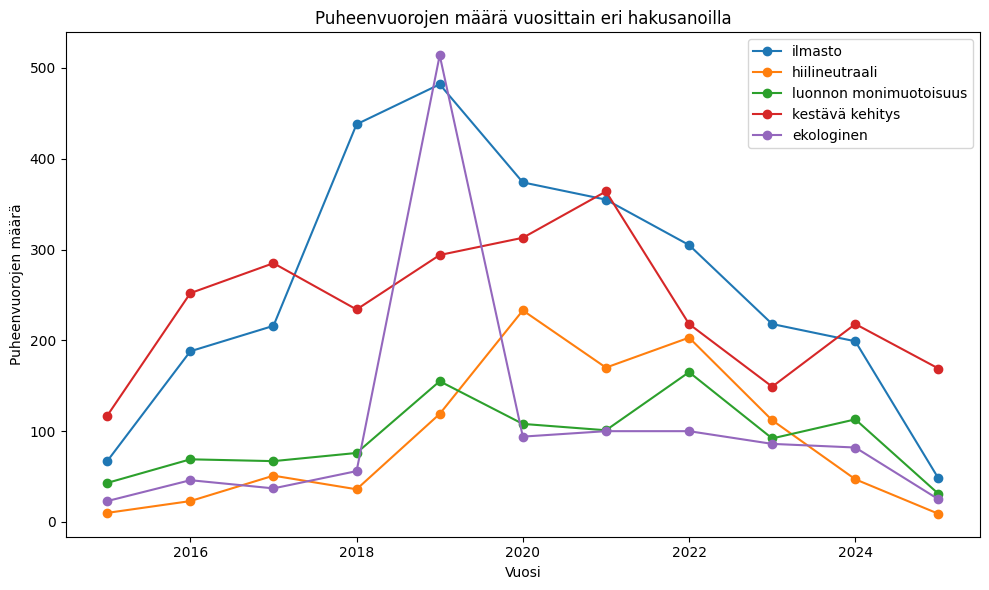

In [34]:
import matplotlib.pyplot as plt

# For convenience, store your DataFrames and their labels in a list
dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

for df, label in dfs:
    # Count speeches per year
    counts = df['date'].dt.year.value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker='o', label=label)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain eri hakusanoilla")
plt.legend()
plt.tight_layout()
plt.show()

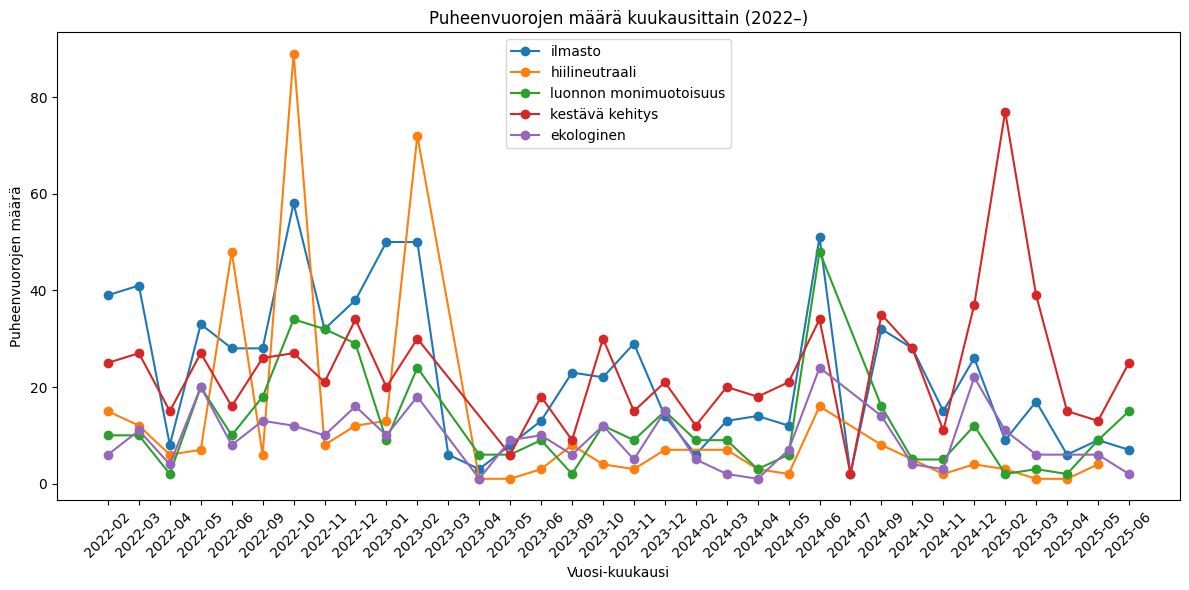

In [35]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(12,6))

for df, label in dfs:
    # Filter for 2022 onwards
    df_recent = df[df['date'] >= "2022-01-01"].copy()
    # Create a "year-month" column for grouping
    df_recent['year_month'] = df_recent['date'].dt.to_period('M')
    # Count speeches by month
    counts = df_recent['year_month'].value_counts().sort_index()
    # Plot
    plt.plot(counts.index.astype(str), counts.values, marker='o', label=label)

plt.xlabel("Vuosi-kuukausi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä kuukausittain (2022–)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

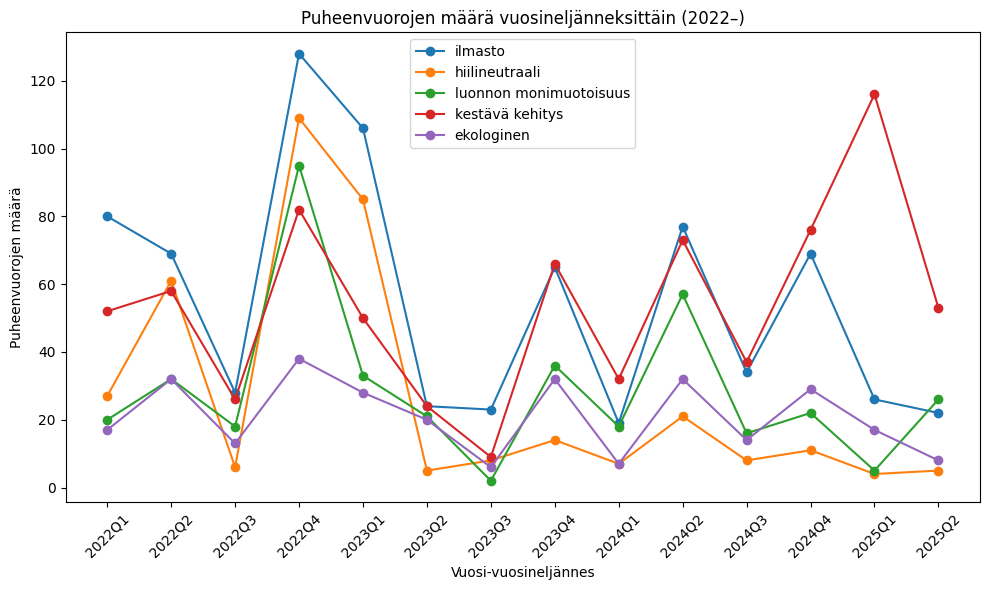

In [36]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

for df, label in dfs:
    df_recent = df[df['date'] >= "2022-01-01"].copy()
    df_recent['quarter'] = df_recent['date'].dt.to_period('Q')
    counts = df_recent['quarter'].value_counts().sort_index()
    plt.plot(counts.index.astype(str), counts.values, marker='o', label=label)

plt.xlabel("Vuosi-vuosineljännes")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosineljänneksittäin (2022–)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

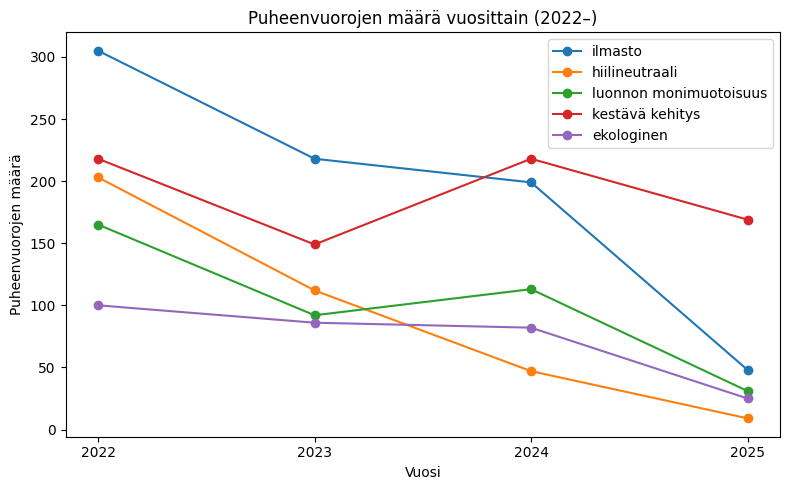

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

for df, label in dfs:
    df_recent = df[df['date'] >= "2022-01-01"].copy()
    counts = df_recent['date'].dt.year.value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker='o', label=label)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain (2022–)")
plt.xticks(counts.index)
plt.legend()
plt.tight_layout()
plt.show()

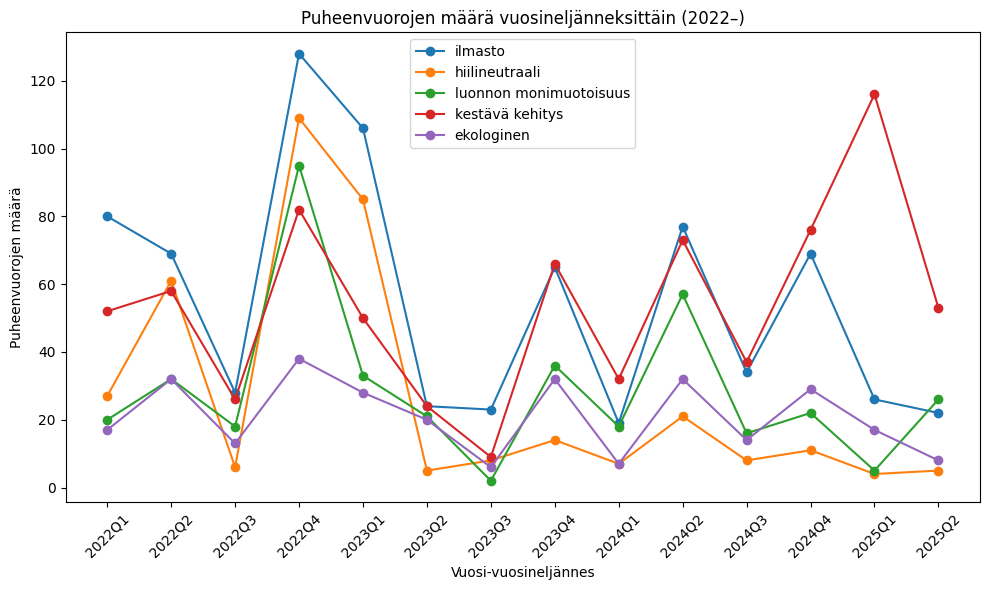

In [40]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

for df, label in dfs:
    df_recent = df[df['date'] >= "2022-01-01"].copy()
    df_recent['quarter'] = df_recent['date'].dt.to_period('Q')
    counts = df_recent['quarter'].value_counts().sort_index()
    plt.plot(counts.index.astype(str), counts.values, marker='o', label=label)

plt.xlabel("Vuosi-vuosineljännes")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosineljänneksittäin (2022–)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

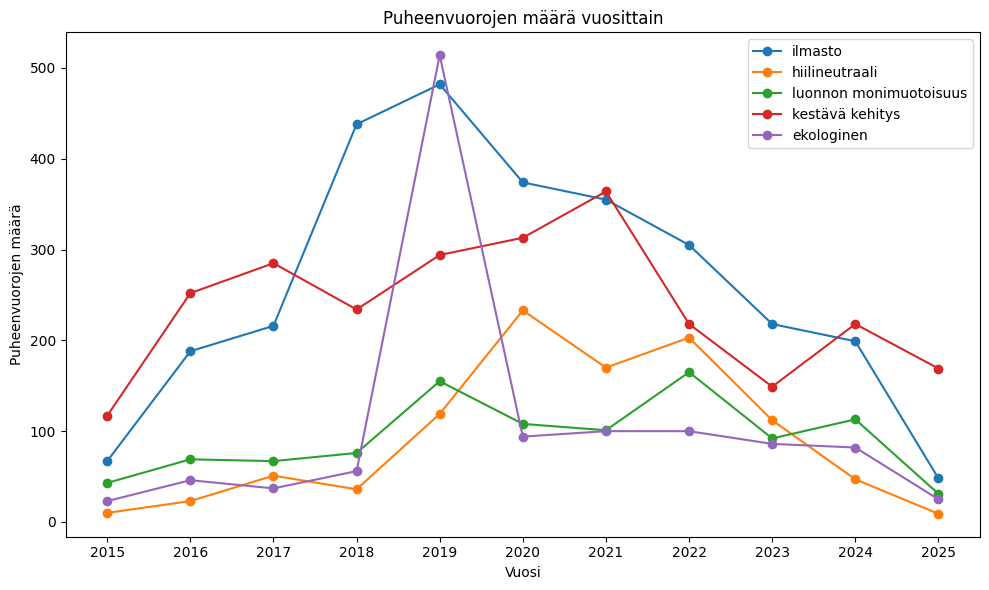

In [42]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

for df, label in dfs:
    # Count by year
    yearly_counts = df['date'].dt.year.value_counts().sort_index()
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label=label)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain")
plt.xticks(yearly_counts.index)
plt.legend()
plt.tight_layout()
plt.show()

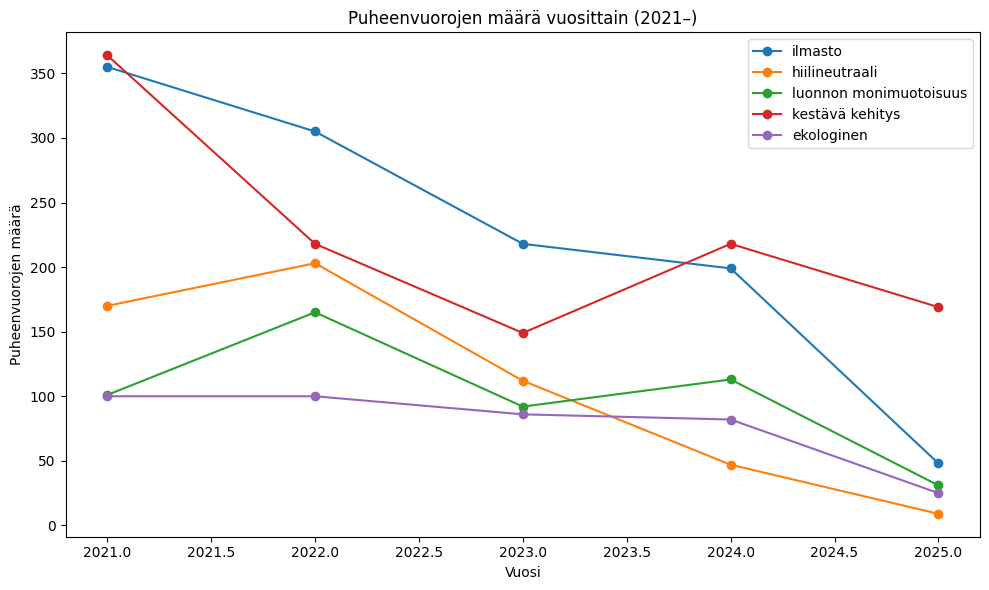

In [43]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

for df, label in dfs:
    df_recent = df[df['date'] >= '2021-01-01'].copy()
    yearly_counts = df_recent['date'].dt.year.value_counts().sort_index()
    plt.plot(yearly_counts.index, yearly_counts.values, marker='o', label=label)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain (2021–)")
plt.legend()
plt.tight_layout()
plt.show()

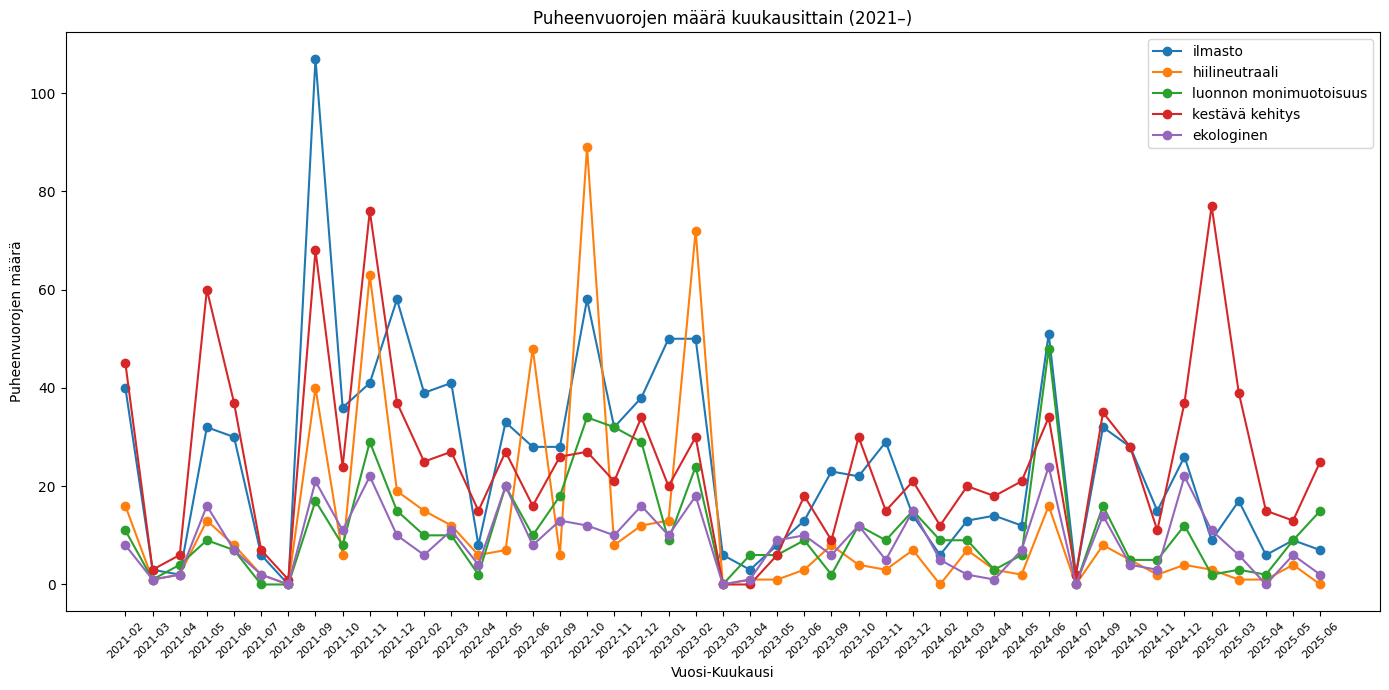

In [44]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(14,7))

# Build a common x-axis: all months present in any df from 2021 onward
all_months = set()
for df, _ in dfs:
    months = df[df['date'] >= '2021-01-01']['date'].dt.to_period('M').unique()
    all_months.update(months)
all_months = sorted(all_months)
x_labels = [str(m) for m in all_months]

for df, label in dfs:
    df_recent = df[df['date'] >= '2021-01-01'].copy()
    df_recent['year_month'] = df_recent['date'].dt.to_period('M')
    monthly_counts = df_recent['year_month'].value_counts().sort_index()
    # Align to all_months (fill missing with 0)
    monthly_counts = monthly_counts.reindex(all_months, fill_value=0)
    plt.plot(x_labels, monthly_counts.values, marker='o', label=label)

plt.xlabel("Vuosi-Kuukausi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä kuukausittain (2021–)")
plt.xticks(rotation=45, fontsize=8)
plt.legend()
plt.tight_layout()
plt.show()

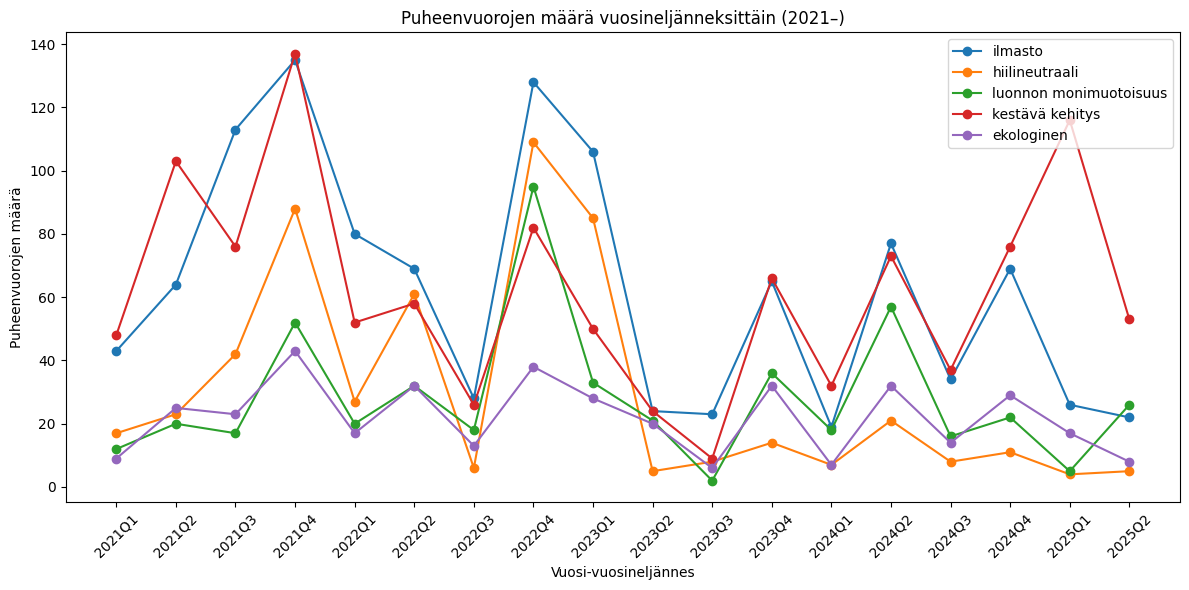

In [45]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(12,6))

# Build a common x-axis: all quarters present in any df from 2021 onward
all_quarters = set()
for df, _ in dfs:
    quarters = df[df['date'] >= '2021-01-01']['date'].dt.to_period('Q').unique()
    all_quarters.update(quarters)
all_quarters = sorted(all_quarters)
x_labels = [str(q) for q in all_quarters]

for df, label in dfs:
    df_recent = df[df['date'] >= '2021-01-01'].copy()
    df_recent['quarter'] = df_recent['date'].dt.to_period('Q')
    quarterly_counts = df_recent['quarter'].value_counts().sort_index()
    # Align to all_quarters (fill missing with 0)
    quarterly_counts = quarterly_counts.reindex(all_quarters, fill_value=0)
    plt.plot(x_labels, quarterly_counts.values, marker='o', label=label)

plt.xlabel("Vuosi-vuosineljännes")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosineljänneksittäin (2021–)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

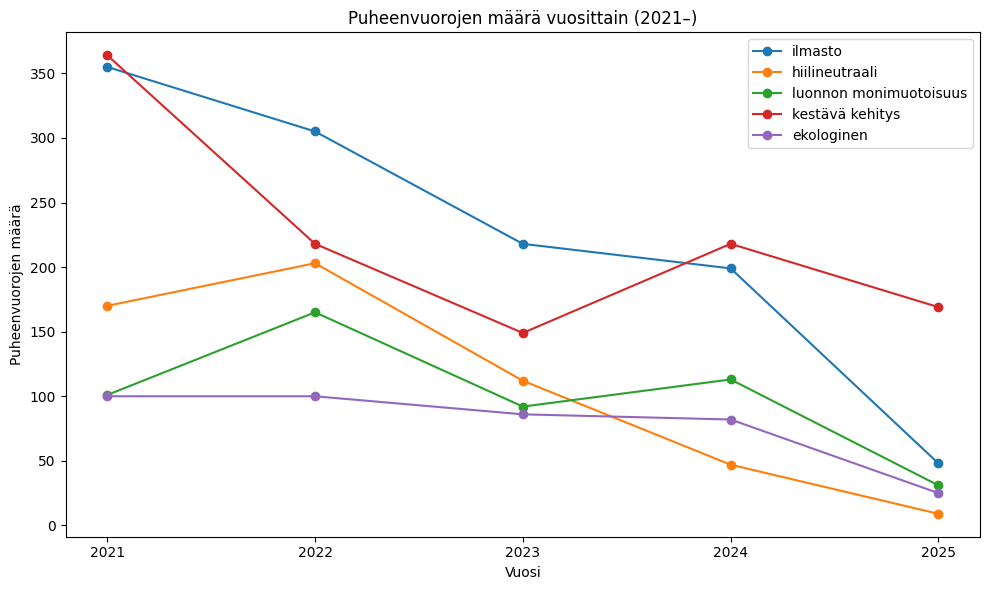

In [46]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

# Build a common x-axis: all years present in any df from 2021 onward
all_years = set()
for df, _ in dfs:
    years = df[df['date'] >= '2021-01-01']['date'].dt.year.unique()
    all_years.update(years)
all_years = sorted(all_years)

for df, label in dfs:
    df_recent = df[df['date'] >= '2021-01-01'].copy()
    yearly_counts = df_recent['date'].dt.year.value_counts().sort_index()
    # Align to all_years (fill missing with 0)
    yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
    plt.plot(all_years, yearly_counts.values, marker='o', label=label)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain (2021–)")
plt.xticks(all_years)
plt.legend()
plt.tight_layout()
plt.show()

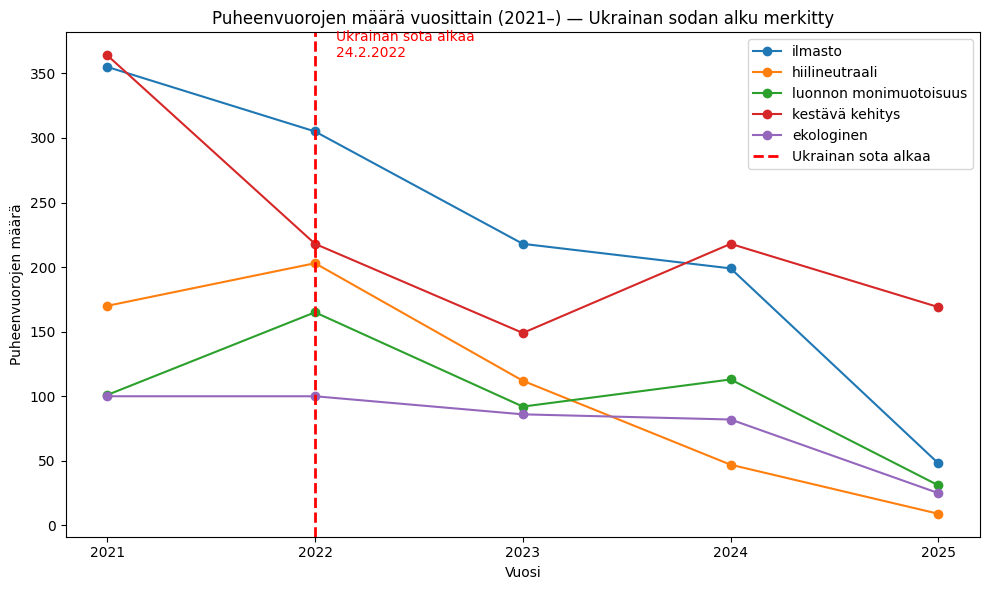

In [47]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

# Build a common x-axis: all years present in any df from 2021 onward
all_years = set()
for df, _ in dfs:
    years = df[df['date'] >= '2021-01-01']['date'].dt.year.unique()
    all_years.update(years)
all_years = sorted(all_years)

for df, label in dfs:
    df_recent = df[df['date'] >= '2021-01-01'].copy()
    yearly_counts = df_recent['date'].dt.year.value_counts().sort_index()
    yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
    plt.plot(all_years, yearly_counts.values, marker='o', label=label)

# Draw vertical line at 2022 for Ukraine war
plt.axvline(x=2022, color='red', linestyle='--', linewidth=2, label="Ukrainan sota alkaa")
plt.text(2022 + 0.1, plt.ylim()[1]*0.95, "Ukrainan sota alkaa\n24.2.2022", color='red', fontsize=10)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain (2021–) — Ukrainan sodan alku merkitty")
plt.xticks(all_years)
plt.legend()
plt.tight_layout()
plt.show()

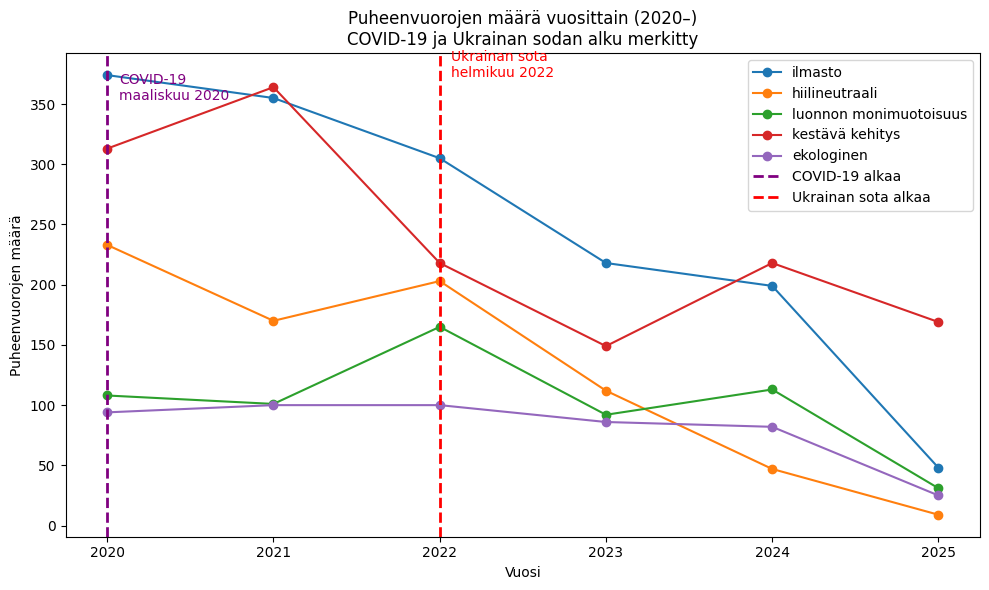

In [48]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

# Build a common x-axis: all years present in any df from 2020 onward
all_years = set()
for df, _ in dfs:
    years = df[df['date'] >= '2020-01-01']['date'].dt.year.unique()
    all_years.update(years)
all_years = sorted(all_years)

for df, label in dfs:
    df_recent = df[df['date'] >= '2020-01-01'].copy()
    yearly_counts = df_recent['date'].dt.year.value_counts().sort_index()
    yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
    plt.plot(all_years, yearly_counts.values, marker='o', label=label)

# Draw vertical lines for COVID and Ukraine events
plt.axvline(x=2020, color='purple', linestyle='--', linewidth=2, label="COVID-19 alkaa")
plt.text(2020 + 0.07, plt.ylim()[1]*0.9, "COVID-19\nmaaliskuu 2020", color='purple', fontsize=10)

plt.axvline(x=2022, color='red', linestyle='--', linewidth=2, label="Ukrainan sota alkaa")
plt.text(2022 + 0.07, plt.ylim()[1]*0.95, "Ukrainan sota\nhelmikuu 2022", color='red', fontsize=10)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain (2020–)\nCOVID-19 ja Ukrainan sodan alku merkitty")
plt.xticks(all_years)
plt.legend()
plt.tight_layout()
plt.show()

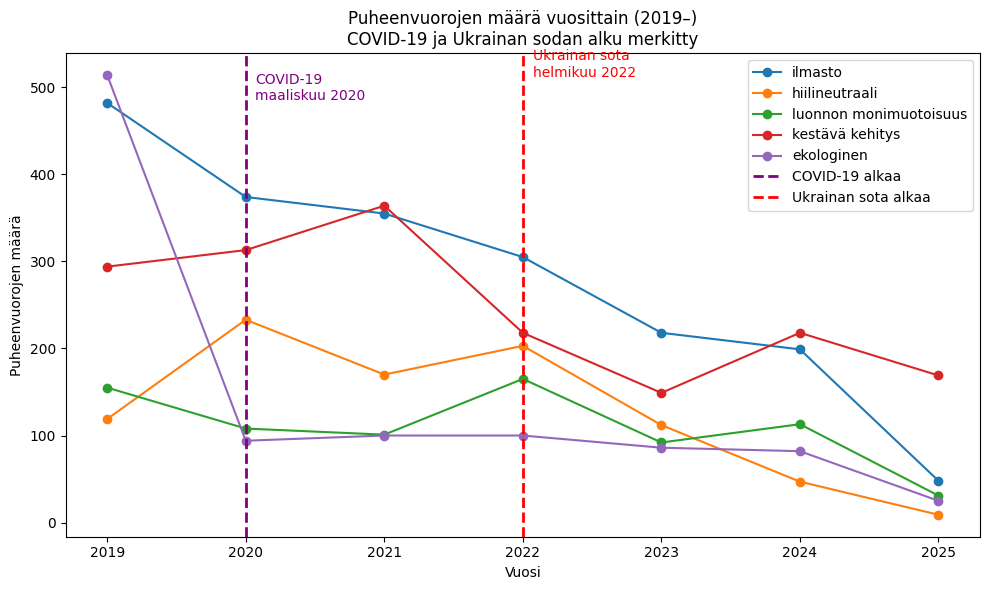

In [49]:
import matplotlib.pyplot as plt

dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

plt.figure(figsize=(10,6))

# Build a common x-axis: all years present in any df from 2019 onward
all_years = set()
for df, _ in dfs:
    years = df[df['date'] >= '2019-01-01']['date'].dt.year.unique()
    all_years.update(years)
all_years = sorted(all_years)

for df, label in dfs:
    df_recent = df[df['date'] >= '2019-01-01'].copy()
    yearly_counts = df_recent['date'].dt.year.value_counts().sort_index()
    yearly_counts = yearly_counts.reindex(all_years, fill_value=0)
    plt.plot(all_years, yearly_counts.values, marker='o', label=label)

# Draw vertical lines for COVID and Ukraine events
plt.axvline(x=2020, color='purple', linestyle='--', linewidth=2, label="COVID-19 alkaa")
plt.text(2020 + 0.07, plt.ylim()[1]*0.9, "COVID-19\nmaaliskuu 2020", color='purple', fontsize=10)

plt.axvline(x=2022, color='red', linestyle='--', linewidth=2, label="Ukrainan sota alkaa")
plt.text(2022 + 0.07, plt.ylim()[1]*0.95, "Ukrainan sota\nhelmikuu 2022", color='red', fontsize=10)

plt.xlabel("Vuosi")
plt.ylabel("Puheenvuorojen määrä")
plt.title("Puheenvuorojen määrä vuosittain (2019–)\nCOVID-19 ja Ukrainan sodan alku merkitty")
plt.xticks(all_years)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
# Define your keywords and DataFrames
dfs = [
    (df_ilmasto, "ilmasto"),
    (df_hiilineutraali, "hiilineutraali"),
    (df_luonnon_monimuotoisuus, "luonnon monimuotoisuus"),
    (df_kestava_kehitys, "kestävä kehitys"),
    (df_ekologinen, "ekologinen")
]

# Build a set of all years present in all DataFrames (e.g., 2019–2025)
all_years = set()
for df, _ in dfs:
    years = df['date'].dt.year.unique()
    all_years.update(years)
all_years = sorted(all_years)

# Create a dict of {year: {keyword: count, ...}, ...}
summary = {year: {} for year in all_years}
for df, label in dfs:
    yearly_counts = df['date'].dt.year.value_counts().sort_index()
    for year in all_years:
        summary[year][label] = yearly_counts.get(year, 0)

# Convert to DataFrame
df_wide = pd.DataFrame.from_dict(summary, orient='index')
df_wide.index.name = 'year'
df_wide = df_wide.reset_index()

print(df_wide)

    year  ilmasto  hiilineutraali  luonnon monimuotoisuus  kestävä kehitys  \
0   2015       67              10                      43              117   
1   2016      188              23                      69              252   
2   2017      216              51                      67              285   
3   2018      438              36                      76              234   
4   2019      482             119                     155              294   
5   2020      374             233                     108              313   
6   2021      355             170                     101              364   
7   2022      305             203                     165              218   
8   2023      218             112                      92              149   
9   2024      199              47                     113              218   
10  2025       48               9                      31              169   

    ekologinen  
0           23  
1           46  
2           

In [51]:
df_wide.to_csv("puheenvuorot_area_bump.csv", index=False)

In [52]:
url_uhanalaiset_lajit = "https://www.eduskunta.fi/FI/search/Sivut/Vaskiresults.aspx#Default=%7B%22k%22%3A%22uhanalaiset%20lajit%22%2C%22r%22%3A%5B%7B%22n%22%3A%22Asiakirjatyyppinimi%22%2C%22t%22%3A%5B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%5D%2C%22o%22%3A%22AND%22%2C%22k%22%3Afalse%2C%22m%22%3A%7B%22%5C%22%C7%82%C7%8250756865656e76756f726f%5C%22%22%3A%22Puheenvuoro%22%7D%7D%5D%2C%22l%22%3A1035%7D"

lines_uhanalaiset_lajit = scrape_puheenvuorot(url_uhanalaiset_lajit)
df_uhanalaiset_lajit = lines_to_df_keyword(lines_uhanalaiset_lajit)

print(df_uhanalaiset_lajit.head())
print(df_uhanalaiset_lajit.shape)

        date                      puhuja
0 2025-05-20    Puhuja:Mäenpää Juha (ps)
1 2025-05-20    Puhuja:Kaleva Atte (kok)
2 2025-05-14  Puhuja:Polvinen Mikko (ps)
3 2025-02-18    Puhuja:Hopsu Inka (vihr)
4 2025-05-20     Puhuja:Kivelä Mai (vas)
(318, 2)


In [53]:
# Group by year and count speeches
yearly_counts = df_uhanalaiset_lajit['date'].dt.year.value_counts().sort_index()
# Convert to DataFrame for export
df_uhanalaiset_summary = yearly_counts.reset_index()
df_uhanalaiset_summary.columns = ['year', 'uhanalaiset lajit']

print(df_uhanalaiset_summary)

    year  uhanalaiset lajit
0   2015                  4
1   2016                 37
2   2017                  7
3   2018                 23
4   2019                 51
5   2020                 19
6   2021                 32
7   2022                 75
8   2023                 17
9   2024                 35
10  2025                 18


In [56]:
# Remove 'Puhuja:' prefix if present
df_ilmasto['puhuja'] = df_ilmasto['puhuja'].str.replace('Puhuja:', '', regex=False)

# Extract name and party
df_ilmasto['name'] = df_ilmasto['puhuja'].str.extract(r'([A-Za-zÄÖÅäöå\s\-]+)\s*\(')[0].str.strip()
df_ilmasto['party'] = df_ilmasto['puhuja'].str.extract(r'\((.*?)\)')[0]

In [57]:
# Count speeches by politician
speaker_counts = df_ilmasto['name'].value_counts()

# Count speeches by party
party_counts = df_ilmasto['party'].value_counts()

In [58]:
print("Top 10 politicians by number of speeches:")
print(speaker_counts.head(10))

print("\nSpeeches by party:")
print(party_counts)

Top 10 politicians by number of speeches:
name
Hassi Satu          95
Elo Tiina           78
Hoskonen Hannu      70
Hopsu Inka          67
Mikkonen Krista     66
Pitko Jenni         55
Kiljunen Kimmo      45
Sarkkinen Hanna     43
Soinikoski Mirka    40
Harjanne Atte       37
Name: count, dtype: int64

Speeches by party:
party
vihr    738
sd      430
kesk    424
ps      278
vas     245
kok     240
r        59
kd       53
sin      20
liik     18
vkk       4
at        2
uv        1
si        1
tl        1
Name: count, dtype: int64


In [60]:
# Ensure 'date' column is string type
df_ilmasto['date'] = df_ilmasto['date'].astype(str)

# Now extract the year
df_ilmasto['year'] = df_ilmasto['date'].str.extract(r'(\d{4})').astype(int)

In [61]:
# Filter for 2024
df_2024 = df_ilmasto[df_ilmasto['year'] == 2024]

# Count speeches by politician and party in 2024
speaker_counts_2024 = df_2024['name'].value_counts()
party_counts_2024 = df_2024['party'].value_counts()

print("Top speakers in 2024:")
print(speaker_counts_2024.head(10))

print("\nSpeeches by party in 2024:")
print(party_counts_2024)

Top speakers in 2024:
name
Pitko Jenni         13
Kallio Vesa          8
Hopsu Inka           7
Hoskonen Hannu       7
Kokko Jani           7
Elo Tiina            6
Perholehto Pinja     5
Mikkonen Krista      4
Koskela Minja        4
Viitala Juha         4
Name: count, dtype: int64

Speeches by party in 2024:
party
sd      54
vihr    40
kesk    25
vas     21
ps      20
kok     12
r        4
kd       2
liik     2
Name: count, dtype: int64


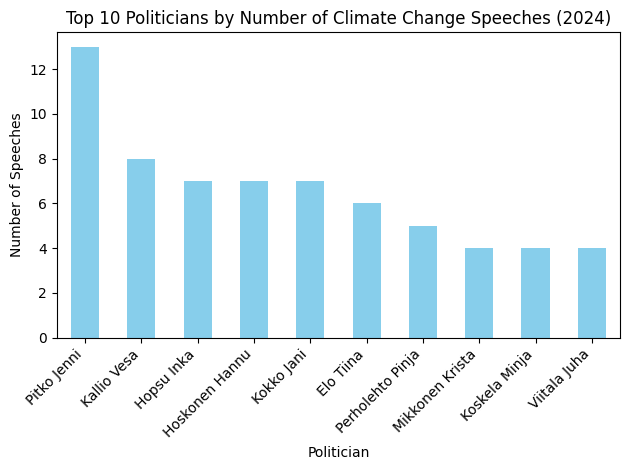

In [62]:
import matplotlib.pyplot as plt

# Plot top 10 speakers
speaker_counts_2024.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Politicians by Number of Climate Change Speeches (2024)')
plt.xlabel('Politician')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

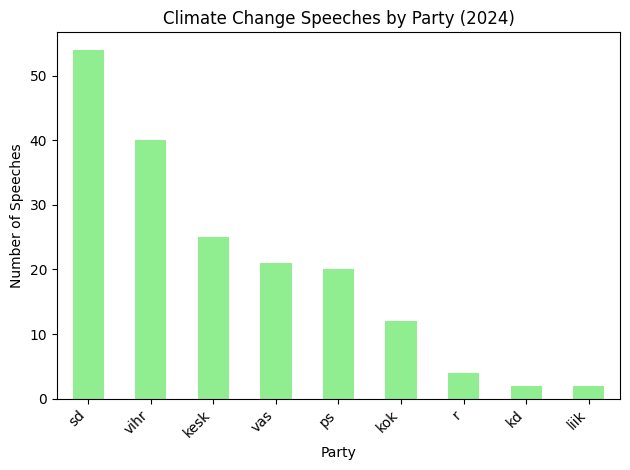

In [63]:
party_counts_2024.plot(kind='bar', color='lightgreen')
plt.title('Climate Change Speeches by Party (2024)')
plt.xlabel('Party')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [66]:
df_ilmasto.tail(50)

,date,puhuja,name,party,year
2840,2024-06-13,Lohi Markus (kesk),Lohi Markus,kesk,2024
2841,2024-06-19,Hoskonen Hannu (kesk),Hoskonen Hannu,kesk,2024
2842,2025-05-13,Kettunen Tuomas (kesk),Kettunen Tuomas,kesk,2025
2843,2025-05-15,,NaN,NaN,2025
2844,2025-05-15,Väyrynen Ville (kok),Väyrynen Ville,kok,2025
2845,2025-05-16,Hänninen Juha (kok),Hänninen Juha,kok,2025
2846,2025-05-20,Harjanne Atte (vihr),Harjanne Atte,vihr,2025
2847,2025-06-10,Pitko Jenni (vihr),Pitko Jenni,vihr,2025
2848,2025-06-10,Vuornos Henrik (kok),Vuornos Henrik,kok,2025
2849,2025-06-11,Lohi Markus (kesk),Lohi Markus,kesk,2025
